In [1]:
import pandas as pd
import numpy as np

In [2]:
# reading the data
train = pd.read_csv("train.csv")
test = pd.read_csv('test.csv')
# Store PassengerId out, to use it at the end for Submission
PassengerId = test['PassengerId']

train.sample(frac=0.1, random_state=None)[:5]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
631,632,0,3,"Lundahl, Mr. Johan Svensson",male,51.0,0,0,347743,7.0542,NaN,S
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0000,NaN,S
374,375,0,3,"Palsson, Miss. Stina Viola",female,3.0,3,1,349909,21.0750,NaN,S
71,72,0,3,"Goodwin, Miss. Lillian Amy",female,16.0,5,2,CA 2144,46.9000,NaN,S
585,586,1,1,"Taussig, Miss. Ruth",female,18.0,0,2,110413,79.6500,E68,S


## Variable Notes
**pclass**: A proxy for socio-economic status (SES)  
1st = Upper  
2nd = Middle  
3rd = Lower  

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...  
**Sibling** = brother, sister, stepbrother, stepsister  
**Spouse** = husband, wife (mistresses and fiancés were ignored)  

parch: The dataset defines family relations in this way...  
Parent = mother, father  
Child = daughter, son, stepdaughter, stepson  
Some children travelled only with a nanny, therefore parch=0 for them.  

In [3]:
# the sample submission file in gender_submission.csv assumes that all female passengers survived (and all male passengers died).
train[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [4]:
# Create a naive model estimates that only females survive.
# and check it's accuracy (about 0.79%)
train["Hypo"] = 0 
train.loc[train["Sex"] == "female", "Hypo"] = 1

train["Result"] = 0
train.loc[train["Hypo"] == train["Survived"], "Result"] = 1
print(train["Result"].value_counts(normalize = True))

1    0.786756
0    0.213244
Name: Result, dtype: float64


In [5]:
# Name, Sex, Tickets, Cabin, Embarked(Port of Embarkation) are objetcs
# Age, Cabin, Embarked have null values and Fare(test)
train.drop(['Hypo', 'Result'], axis=1, inplace=True)
train.info(), train.isnull().sum(), test.isnull().sum()
# import pandas_profiling
# train.profile_report()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


(None, PassengerId      0
 Survived         0
 Pclass           0
 Name             0
 Sex              0
 Age            177
 SibSp            0
 Parch            0
 Ticket           0
 Fare             0
 Cabin          687
 Embarked         2
 dtype: int64, PassengerId      0
 Pclass           0
 Name             0
 Sex              0
 Age             86
 SibSp            0
 Parch            0
 Ticket           0
 Fare             1
 Cabin          327
 Embarked         0
 dtype: int64)

# Feature Engineering

In [6]:
# list of our 2 datasets
datasets = [train, test]

In [7]:
# Name
import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

for d in datasets:
    d['Title'] = d['Name'].apply(get_title)

print(pd.crosstab(train['Title'], train['Sex']), '\n')

for d in datasets:
    d['Title'] = d['Title'].replace( ['Capt', 'Col', 'Countess', 'Don',
                                     'Dr', 'Jonkheer', 'Lady', 'Major',
                                     'Rev', 'Sir'], 'Rare' )

    d['Title'] = d['Title'].replace('Mlle', 'Miss')
    d['Title'] = d['Title'].replace('Ms', 'Miss')
    d['Title'] = d['Title'].replace('Mme', 'Mrs')

# Check the title impact on survival rate.
# Miss is the most Survived
print(train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

# Mapping titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for d in datasets:
    d['Title'] = d['Title'].map(title_mapping)
    d['Title'] = d['Title'].fillna(0)
    d['Title'] = d['Title'].astype(int)

Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1 

    Title  Survived
0  Master  0.575000
1    Miss  0.702703
2      Mr  0.156673
3     Mrs  0.793651
4    Rare  0.347826


In [8]:
# Sex
for d in datasets:
    d['Sex'] = d['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

In [9]:
# Age
for d in datasets:
    d["Age"] = d["Age"].fillna(train["Age"].dropna().median())


train['AgeGroups'] = pd.cut(train['Age'], 5)
print(train[['AgeGroups', "Survived"]].groupby(['AgeGroups'], as_index=False).mean())

for d in datasets:
    d.loc[ d['Age'] <= 16, 'Age'] = 0
    d.loc[ (d['Age'] > 16) & (d['Age'] <= 32), 'Age'] = 1
    d.loc[ (d['Age'] > 32) & (d['Age'] <= 48), 'Age'] = 2
    d.loc[ (d['Age'] > 48) & (d['Age'] <= 64), 'Age'] = 3
    d.loc[ (d['Age'] > 64) & (d['Age'] <= 80), 'Age'] = 4
    
    d["Age"] = d["Age"].astype(int)

          AgeGroups  Survived
0    (0.34, 16.336]  0.550000
1  (16.336, 32.252]  0.344168
2  (32.252, 48.168]  0.404255
3  (48.168, 64.084]  0.434783
4    (64.084, 80.0]  0.090909


In [10]:
## Status
# SibSp and Parch
# sibsp: Sibling(brother, sister, stepbrother, stepsister) or Spouse(husband, wife)
# parch: Parent(mother, father) or Child(daughter, son, stepdaughter, stepson)
# With the number of siblings/spouse and the number of children/parents we can create new feature called Family Size.
for d in datasets:
    d['FamilySize'] = d['SibSp'] + d['Parch'] + 1
print(train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean(), '\n')

for d in datasets:
    d['IsAlone'] = 0
    d.loc[d['FamilySize'] == 1, 'IsAlone'] = 1
train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000 



,IsAlone,Survived
0,0,0.505650
1,1,0.303538


In [11]:
# Fare(Passenger fare)
for d in datasets:
    d['Fare'] = d['Fare'].fillna( train['Fare'].median() )

train['FareGroups'] = pd.qcut(train['Fare'], 5)
print(train[['FareGroups', "Survived"]].groupby(['FareGroups'], as_index=False).mean())

for d in datasets:
    d.loc[ d['Fare'] <= 7, 'Fare'] = 0
    d.loc[ (d['Fare'] > 7) & (d['Fare'] <= 10), 'Fare'] = 1
    d.loc[ (d['Fare'] > 10) & (d['Fare'] <= 21), 'Fare'] = 2
    d.loc[ (d['Fare'] > 21) & (d['Fare'] <= 39), 'Fare'] = 3
    d.loc[ (d['Fare'] > 39) & (d['Fare'] <= 512), 'Fare'] = 4
    
    d['Fare'] = d['Fare'].astype(int)

          FareGroups  Survived
0    (-0.001, 7.854]  0.217877
1      (7.854, 10.5]  0.201087
2     (10.5, 21.679]  0.424419
3   (21.679, 39.688]  0.444444
4  (39.688, 512.329]  0.642045


In [12]:
# Cabin(Cabin number)
# train["Cabin"].describe()
for d in datasets:
    d['HasCabin'] = d["Cabin"].apply(lambda x: 0 if type(x) == float else 1)

train[['HasCabin', 'Survived']].groupby(['HasCabin'], as_index=False).mean()

,HasCabin,Survived
0,0,0.299854
1,1,0.666667


In [13]:
# Embarked(Port of Embarkation)
# C = Cherbourg, Q = Queenstown, S = Southampton
for d in datasets:
    d['Embarked'] = d['Embarked'].map( {'C':0, 'Q':1, 'S':2} )
    d['Embarked'] = d['Embarked'].fillna(2) # S == 2 (mode)

## Fearture Selection

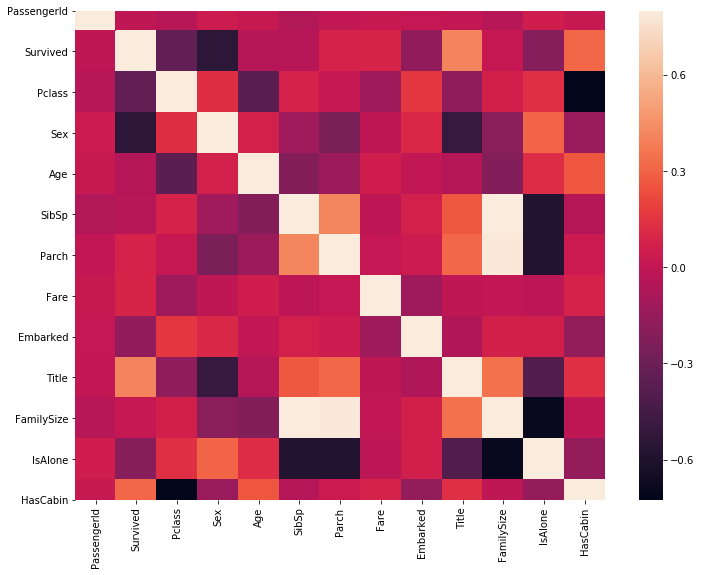

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# correlation matrix 
plt.figure(figsize=(12, 9))
sns.heatmap(train.corr(), vmax=.8, square=True);

In [38]:
# Numerical Variables correlation  
train[train.columns[1:]].corr()['Survived'][:-1]
# Age, SibSp, FamilySize has the lowest correlation

Survived      1.000000
Pclass       -0.338481
Sex          -0.543351
Age          -0.043800
SibSp        -0.035322
Parch         0.081629
Fare          0.086528
Embarked     -0.167675
Title         0.407753
FamilySize    0.016639
IsAlone      -0.203367
Name: Survived, dtype: float64

In [39]:
# Feature Selection
train = train.drop(['AgeGroups', 'FareGroups'], axis = 1)
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp', 'Parch', 'FamilySize', 'Age']

train = train.drop(drop_elements, axis = 1)
test = test.drop(drop_elements, axis = 1)

train.sample(frac=0.1, random_state=None)[:5]

,Survived,Pclass,Sex,Fare,Embarked,Title,IsAlone,HasCabin
148,0,2,1,3,2.0,1,0,1
521,0,3,1,1,2.0,1,1,0
700,1,1,0,4,0.0,3,0,1
291,1,1,0,4,0.0,3,0,1
591,1,1,0,4,0.0,3,0,1


# Classifier Comparison
good!  
now we have a clean dataset and ready to predict. let's find which classifier works better on this dataset.

In [58]:
from sklearn.model_selection import train_test_split

features = ['Pclass','Sex','Fare','Embarked','Title','IsAlone','HasCabin']
X_train, X_test, y_train, y_test = train_test_split(train[features], train['Survived'],
                                                    test_size=0.33, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((596, 7), (596,), (295, 7), (295,))

In [65]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

logreg = LogisticRegression(C=1, solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

f1_score(y_test, y_pred)

0.7510204081632653

In [72]:
# Support Vector Machines
from sklearn.svm import SVC

svc = SVC(kernel='rbf', gamma='auto', C=0.2)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

f1_score(y_test, y_pred)

0.8016877637130801

In [52]:
# K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 11)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

f1_score(y_test, y_pred)

0.7610619469026548

In [73]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth=6)
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

f1_score(y_test, y_pred)

0.7123287671232875

In [75]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=13, max_depth=4, n_jobs=5)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)

f1_score(y_test, y_pred)

0.7565217391304347

# Submission

most of the classifiers classify the data similarly.  
But i will choose SVC for Submission.

In [55]:
# Train with more data
X_train = train.drop("Survived", axis=1)
y_train = train["Survived"]
X_test  = test
X_train.shape, y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [56]:
# For test dataset (submission)
svc = SVC(kernel='rbf', gamma='auto', C=0.4)
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)

In [57]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': y_pred })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)